# Training a Smartcab Using Q-Learning from scratch

In this project, we are going to implement Q learning from scratch in a game named Smartcab. We are going to build an agent who is going to play and learn using penalties and rewards that it gets from each stage

## Objective of the environment

There are 4 locations which are labeled by different letters: R, G, B and Y. Our goal is to pick up the passenger from one location and drop him off at another. This is a text based environment. So everything is in ASCII character.

## Import necessary libraries

In [1]:
import gym
#importing taxi-v2 environment
taxi_env = gym.make('Taxi-v2')

## Initialization and rendering

In [2]:
print("Action space {}".format(taxi_env.action_space))
print("State Space {}".format(taxi_env.observation_space))

taxi_init = taxi_env.reset()
print("Initiate state {}".format(taxi_init))

Action space Discrete(6)
State Space Discrete(500)
Initiate state 313


From above we can see that, we have action space 6 which means we have 6 actions:
<p>North, East, South, West, Pickup and Drop-off</p>

We have state space value 500. Let's see how we achieve that:
<table>
    <thead>
        <th>Information</th>
        <th>Possible Values</th>
        <th>Number of possible values</th>
    </thead>
    <tbody>
        <tr>
            <td>Taxi row</td>
            <td>0,1,2,3,4</td>
            <td>5</td>
        </tr>
        <tr>
            <td>Taxi column</td>
            <td>0,1,2,3,4</td>
            <td>5</td>
        </tr>
        <tr>
            <td>Destination</td>
            <td>R,G,B,Y</td>
            <td>4</td>
        </tr>
        <tr>
            <td>Passenger location</td>
            <td>R,G,B,Y, Onboard</td>
            <td>5</td>
        </tr>
    </tbody>
</table>

State space = 5x5x4x5 = 500

Initiate space is 313. It is an encoded value which is combined of taxi location, destination and passenger location. Let's try to understand that in next section.

## Decoding initiate space

In [3]:
print("Decode state ", list(taxi_env.env.decode(taxi_init)))
taxi_env.render() #to see what is the current environment

Decode state  [3, 0, 3, 1]
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



We can see that, after decoding the initiate space, we have a list of value.
<br>In list, first two value indicates the taxi position which is (3,0) (row 3 and column 0). Here the yellow bar indicates as taxi. After that 3rd value in list is 3 which indicates pickup location. It is colored as blue. The last value indicates drop-off location which is 1. In this case, it is G and color as magenta. Besides, in this environment, we can see that, there are some black bars. These mean that, taxi can not go through those bars.

## The reward table

In [4]:
taxi_env.env.P[taxi_init]

{0: [(1.0, 413, -1, False)],
 1: [(1.0, 213, -1, False)],
 2: [(1.0, 313, -1, False)],
 3: [(1.0, 313, -1, False)],
 4: [(1.0, 313, -10, False)],
 5: [(1.0, 313, -10, False)]}

These are the rewards that is set by environment which we get after taking any action: <br>

Default reward: -1<br>
Drop-off at right location: 20<br>
Pickup at wrong location: -10<br>
Drop-off at wrong location: -10<br>

That means the higher time we take to Pickup or Drop-off any passenger, the negative value will be increasing.
<br>From this result, we can see that, from current position, if we take north/south/east/west, we would be rewarded with -1 and if we drop-off/pickup in current position, we would be rewarded with -10.
<br> There is also a boolean value to indicate whether the episode is over by performing this action or not

## Initiate a dump agent and evaluate

We can measure the performance using following categories:
<ul>
    <li>Time Taken</li>
    <li>Number of penalties</li>
    <li>Reward obtained</li>
</ul>

In [5]:
#to calculate the performance, we are running the same loop but with some additional parameter
epochs, penalties, total_reward = 0, 0, 0
episodes = 100 #we are running for 100 times
current_episode = 0
while current_episode < episodes:
    reward = 0
    done = False
    while not done:
        
        #picking up a random action from action space and current position
        some_action = taxi_env.action_space.sample()
        
        #executing that action. This returns us next stage, the reward we got from taking that step, boolean value 
        #which indicates whether our episode is done or not and some additional debugging info
        state, reward, done, info = taxi_env.step(some_action)
        
        #if the reward is -10, that means we have taken a wrong action and number of penalty is incremented by 1
        if(reward == -10):
            penalties += 1
        epochs += 1
        total_reward += reward
    
    current_episode += 1
    taxi_env.reset()

print("Avg reward per move {}".format(total_reward / float(epochs)))
print("Avg time steps per episodes {}".format(epochs / float(episodes)))
print("Avg num of penalties per episode {}".format(penalties / float(episodes)))

Avg reward per move -3.911261582323592
Avg time steps per episodes 196.42
Avg num of penalties per episode 63.7


Here we can see that, average reward per move is 3.9113 which is bad as we have gone to negative value. Average time steps per episodes and average num of penalties per episode are also high.

These shows that, our initial agent is failed miserably in this taxi-v2 environment

## Implementing the Q learning from scratch

### Q-Learning parameters

In [6]:
alphaList = [0.5, 0.6, 0.7] #this is the learning rate
gammaList = [0.5, 0.6, 0.7] #the discount factor
epsilonList = [0.7, 0.8, 0.9] #to balance between exploration and exploitation. 
#This value means we are more prone to exploration

#if epsilon is 0, that means we are only going to trust our experience to learn

### Initializing Q table

In [7]:
import numpy as np
from collections import defaultdict

#initially, the q table is set to 0 and its size is state_space_size x action_space_size
q_table = np.zeros([taxi_env.observation_space.n, taxi_env.action_space.n])

### Updating the Q-values after every epoch

![https://s31.postimg.cc/tmim26kqx/q_learning_equation.png](https://s31.postimg.cc/tmim26kqx/q_learning_equation.png?dl=1)

In [8]:
def q_learning(q_table, env, state, epsilon, alpha, gamma):
    """
    Update the q table based on q learning equation
    """
    
    #This if condition to decide whether we do exploration or exploitation based on epsilon value
    #Firstly we sample a random number between 0 and 1 and compare with epsilon
    #if is greater than epsilon that mean we are going to explore, we select a random from action_space from that state
    #if not that means we are going to exploit,then we select a optimal action from q table
    if(random.uniform(0,1) > epsilon):
        action = taxi_env.action_space.sample()
    else:
        #it compares all the q values for all the actions and returns the highest q valued action
        action = chooseOptimalAction(q_table, state)
        
    #executing that action and obtaining the next state.
    next_state, reward, done, _ = taxi_env.step(action)
    
    #extract the old q value from table for that action and state
    old_q_value = q_table[state][action]
    
    #then we calculate the future optimal value taking numpy max on row corrosponding to the next state in q table
    next_max = np.max(q_table[next_state])
    
    #calculate the updated q value
    new_q_value = (1-alpha)* old_q_value + alpha * (reward + gamma * next_max)
    
    #update q table with new q value
    q_table[state][action] = new_q_value
    
    
    return next_state, reward, done

In [9]:
import random

def chooseOptimalAction(q_table, state):
    """
    We are using np.argmax to get the highest index of the column having the highest q value in the row correspoing 
    to the state in the q table
    """
    
    """
    This if to check when all the q table values are 0, that means this state row has not been explored
    In that state,we are returing any random action instead of returning the first action which np.argmax does by 
    default if all the values are equal
    """
    if(np.sum(q_table[state]) == 0):
        return random.randint(0, q_table.shape[1]-1)
    
    return np.argmax(q_table[state])

In [10]:
def train_agent(q_table, env, num_episodes, epsilon, alpha, gamma):
    
    """
    Function to train our agent
    Parameters are: q_table, env, num_episodes (number of episodes to run or train agent), epsilon, alpha, gama
    """
    
    for i in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            state, reward, done = q_learning(q_table, env, state, epsilon, alpha, gamma)

    return q_table

In [11]:
"""Evaluation function for agent by exploition of q table"""
def run_episodes(q_table, env, num_trials):
    data_by_episode = [] #list to keep track of all the variables that we need to calculate performance
    for i in range(num_trials):
        state = env.reset()
        epochs, penalties, episode_reward = 0, 0, 0
        
        done = False
        while not done:
            
            next_action = chooseOptimalAction(q_table, state)
            state, reward, done, _ = env.step(next_action)   
            
            if(reward == -10):
                penalties += 1
                
            epochs += 1
            
            episode_reward += reward
            
        data_by_episode.append((epochs, penalties, episode_reward))
    return data_by_episode

In [12]:
"""Evaluation function for agent by exploition of q table"""
def calculate_episode(trial_data):
    epochs, penalties, reward = zip(*trial_data)
    total_epochs, total_penalties, total_reward = sum(epochs), sum(penalties), sum(reward)
    num_trials = len(epochs)
    avg_time = total_epochs / float(num_trials)
    avg_penalties = total_penalties / float(num_trials)
    avg_reward_per_move = total_reward / float(total_epochs)
    return (avg_time, avg_penalties, avg_reward_per_move)

### Train the agent

In [13]:
data_plot = []
for i in range(3):
    epsilon = epsilonList[i]
    alpha = alphaList[i]
    gamma = gammaList[i]
    data_to_plot = []
    q_table = np.zeros([taxi_env.observation_space.n, taxi_env.action_space.n])
    train_episodes_before_eval = 100 #number of times to train the agent
    num_episodes_for_eval = 50 #number of episode to test agent performance
    while True:

        #training the agent and updating the q table
        q_table = train_agent(q_table, taxi_env, train_episodes_before_eval, epsilon=epsilon,alpha=alpha, gamma=gamma)

        #testing the agent performance
        trial_data = run_episodes(q_table, taxi_env,num_episodes_for_eval)
        """
        What is happening in above two lines that, we are continuosly training our agent for 100 episodes and 
        testing it for 50 episodes
        """

        #after testing we are calculating the performance of agent
        avg_time, avg_penalties, avg_reward_per_move = calculate_episode(trial_data)

        #list to plot the data
        data_to_plot.append((avg_time, avg_penalties, avg_reward_per_move))


        """
        Time to stop learning the agent can be decided by looking into three factors:
        1. Agent finishes the training fast enough for several episodes continuosly
        2. No penalties
        3. Average reward of successive episodes is greater than the threshold value

        So here we checking if penalties is 0 and average reward is greater than thrshold, in this case 0.8
        """

        if avg_penalties == 0 and avg_reward_per_move > 0.8:
            print("When alpha = {} , gamma = {} , epsilon = {}".format(alpha, gamma, epsilon))
            print("Avg reward per move {}".format(avg_reward_per_move))
            print("Avg time steps taken {}".format(avg_time))
            print("Avg num of penalties incurred {}".format(avg_penalties))
            print("======================================")
            break
    data_plot.append(data_to_plot)

When alpha = 0.5 , gamma = 0.5 , epsilon = 0.7
Avg reward per move 0.8197573656845754
Avg time steps taken 11.54
Avg num of penalties incurred 0.0
When alpha = 0.6 , gamma = 0.6 , epsilon = 0.8
Avg reward per move 0.8103448275862069
Avg time steps taken 11.6
Avg num of penalties incurred 0.0
When alpha = 0.7 , gamma = 0.7 , epsilon = 0.9
Avg reward per move 0.8041237113402062
Avg time steps taken 11.64
Avg num of penalties incurred 0.0


<table>
    <thead>
        <th>Specs</th>
        <th>Avg. reward per move</th>
        <th>Time steps per episode</th>
        <th>Avg. number of penalties</th>
    </thead>
    <tbody>
        <tr>
            <td>Alpha=0.5<br>Gamma=0.5<br>Epsilon=0.7</td>
            <td>0.8197574</td>
            <td>11.54</td>
            <td>0.0</td>
        </tr>
        <tr>
            <td>Alpha=0.6<br>Gamma=0.6<br>Epsilon=0.8</td>
            <td>0.810345</td>
            <td>11.60</td>
            <td>0.0</td>
        </tr>
        <tr>
            <td>Alpha=0.7<br>Gamma=0.7<br>Epsilon=0.9</td>
            <td>0.804124</td>
            <td>11.64</td>
            <td>0.0</td>
        </tr>
    </tbody>
</table>

As we can see from that result that, among the 3 scenarios, 1st scenario where alpha = 0.5, gamma = 0.5 and epsilon = 0.7 provided us the shortest time steps taken and reward is more than others.

### Plot result

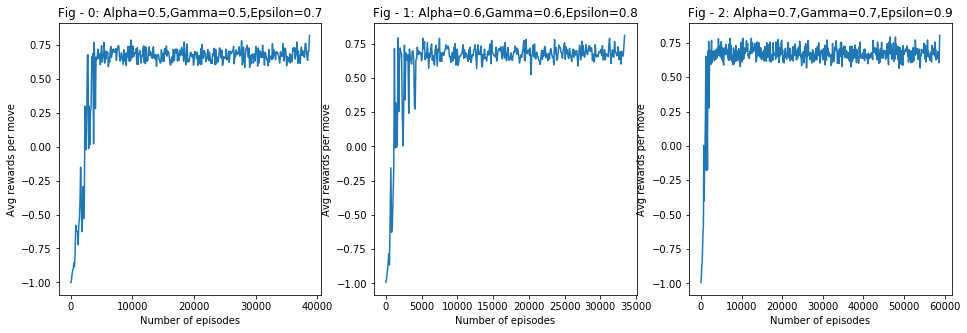

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, len(alphaList), figsize=(16,5), squeeze=False)
for index in range(len(alphaList)):
    alpha = alphaList[index]
    gamma = gammaList[index]
    epsilon = epsilonList[index]
    plt.subplot(1, 3, (index+1))
    plt.title("Fig - {}: Alpha={},Gamma={},Epsilon={}".format(index, alpha,gamma,epsilon))
    rewards_by_eval = [data[2] for data in data_plot[index]]
    episode_counts = [j*train_episodes_before_eval for j in range(len(data_plot[index]))]
    plt.plot(episode_counts, rewards_by_eval)
    plt.xlabel("Number of episodes")
    plt.ylabel("Avg rewards per move")
plt.show()

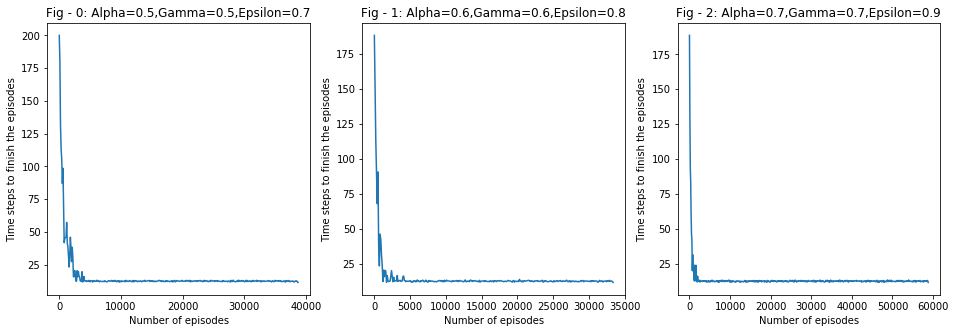

In [15]:
fig, axes = plt.subplots(1, len(alphaList), figsize=(16,5), squeeze=False)
for index in range(len(alphaList)):
    alpha = alphaList[index]
    gamma = gammaList[index]
    epsilon = epsilonList[index]
    plt.subplot(1, 3, (index+1))
    plt.title("Fig - {}: Alpha={},Gamma={},Epsilon={}".format(index,alpha,gamma,epsilon))
    times_steps_by_eval = [data[0] for data in data_plot[index]]
    episode_counts = [j*train_episodes_before_eval for j in range(len(data_plot[index]))]
    plt.plot(episode_counts, times_steps_by_eval)
    plt.xlabel("Number of episodes")
    plt.ylabel("Time steps to finish the episodes")
plt.show()

## Learnings

### Comparing agents performances

<table>
    <thead>
        <th></th>
        <th>Initial Agent</th>
        <th>Q-Learning Agent (Using the best result)</th>
    </thead>
    <tbody>
        <tr>
            <td>Time steps</td>
            <td>196.42</td>
            <td>11.54</td>
        </tr>
        <tr>
            <td>Number of penalties</td>
            <td>63.7</td>
            <td>0.0</td>
        </tr>
        <tr>
            <td>Rewards per move</td>
            <td>-3.91126</td>
            <td>0.819757</td>
        </tr>
    </tbody>
</table>
As we can see from this performance table that, our agent learns better after implementing the Q-Learning method.

### Improvements

<ul>
    <li>Initialize Q values when the (state,action) combination is encountered to utilize the memory. Because there might be some state,action which might be never occured in environment</li>
    <li>Implement epsilon decay in which we use exploration in beginning and exploitation as training progress</li>
</ul>

### Limitation of Q-Learning

<ul>
    <li>Not scalable. If we change the dimension to any large number so the q table and state space will grow explonatially in size.</li>
    <li>Sparse rewards cause issues. For example it can not will a puzzle or chess game by exploring the actions.</li>
    <li>Fails in continous space because it requires discrete action space.</li>
</ul>